In [5]:
# Cloning Git Repository to access Python Files
!git clone https://github.com/aakashvardhan/s5-pytorch-tutorial.git

Cloning into 's5-pytorch-tutorial'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11 (delta 1), reused 8 (delta 1), pack-reused 0
Receiving objects: 100% (11/11), 5.33 KiB | 1.78 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [7]:
'''The sys module provides access to some variables
used or maintained by the Python interpreter and to functions
that interact strongly with the interpreter. It's commonly used for
manipulating Python runtime environment, handling command-line arguments,
and system-specific parameter'''
import sys

In [8]:
sys.path.append('./s5-pytorch-tutorial')

In [19]:
# Importing torchvision for handling datasets and applying transformations
from torchvision import datasets, transforms

# Importing torchsummary for displaying a summary of your PyTorch model, including the shape of the input data and the total number of parameters,
!pip install torchsummary
from torchsummary import summary

# Importing PyTorch Library
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Importing python files, including CNN model, train & test the model
from model import Net
from utils import train, test

# Import the Matplotlib library for plotting
import matplotlib.pyplot as plt

In [10]:
# This block of code is used to define transformations for the training dataset.
train_transforms = transforms.Compose([
    # Randomly applies a center crop of size 22 to the input image with a probability of 0.1.
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    # Resizes the input image to a size of 28x28 pixels.
    transforms.Resize((28, 28)),
    # Randomly rotates the input image within a range of -15 to 15 degrees. The areas left after rotation are filled with 0 (black).
    transforms.RandomRotation((-15., 15.), fill=0),
    # Converts the input image to a PyTorch tensor.
    transforms.ToTensor(),
    # Normalizes the input tensor with a mean of 0.1307 and a standard deviation of 0.3081.
    transforms.Normalize((0.1307,), (0.3081,)),
])

# This block of code is used to define transformations for the testing dataset.
test_transforms = transforms.Compose([
    # Converts the input image to a PyTorch tensor.
    transforms.ToTensor(),
    # Normalizes the input tensor with a mean of 0.1407 and a standard deviation of 0.4081.
    transforms.Normalize((0.1407,), (0.4081,))
])

In [11]:
# MNIST Training dataset with specified transformation
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
# MNIST Testing dataset with specified transformation
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 21035336.35it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 33178771.25it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 68257909.56it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2058626.41it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [12]:
# Set the batch size to 512, indicating the number of samples to be processed in one go.
batch_size = 512

# Define a dictionary of keyword arguments for the DataLoader:
# 'batch_size': Specifies the number of samples in each batch.
# 'shuffle': If True, the dataset will be shuffled at the beginning of each epoch to reduce model overfitting.
# 'num_workers': Sets the number of subprocesses to use for data loading. Utilizing multiple workers can enhance data loading throughput.
# 'pin_memory': When set to True and using a CUDA-enabled GPU, this option pins memory, potentially speeding up data transfer to the GPU.
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

# Initialize the DataLoader for the test dataset.
# 'test_data': The dataset to use for testing.
# The DataLoader handles efficient loading of data from 'test_data' using the parameters defined in 'kwargs'.
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

# Initialize the DataLoader for the training dataset.
# 'train_data': The dataset to use for training. The DataLoader will shuffle this data if 'shuffle' is True, as per 'kwargs'.
# This DataLoader facilitates efficient loading of training data, respecting the parameters specified in 'kwargs'.
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

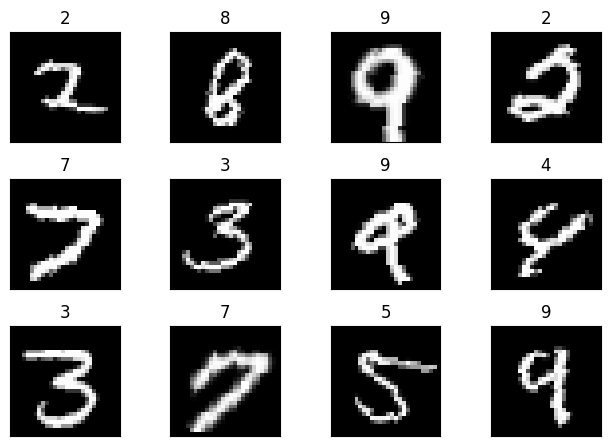

In [13]:
# Retrieve the first batch of data and labels from the training DataLoader
batch_data, batch_label = next(iter(train_loader))

# Initialize a new figure for plotting
fig = plt.figure()

# Loop over the first 12 images and labels in the batch.
for i in range(12):
  # Create a 3x4 grid of subplots. The index of the current subplot (i+1) is set to active
  plt.subplot(3,4,i+1)
  # Adjust the layout to prevent overlapping of subplot elements.
  plt.tight_layout()
  # Display an image. 'squeeze(0)' removes a dimension of size 1, which is common for grayscale images in PyTorch.
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  # Set the title of the subplot to the label of the current image. '.item()' converts a PyTorch scalar to a Python number.
  plt.title(batch_label[i].item())
  # Remove the x-axis ticks.
  plt.xticks([])
  # Remove the y-axis ticks.
  plt.yticks([])

In [18]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [20]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=2.2969 Batch_id=9 Accuracy=11.66:   8%|▊         | 10/118 [00:45<08:13,  4.57s/it]


KeyboardInterrupt: 